In [69]:
from pytorchcv.model_provider import get_model
import torch

net = get_model("zfnet", pretrained=True)

In [39]:
from torchsummary import summary

summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 110, 110]          14,208
              ReLU-2         [-1, 96, 110, 110]               0
          AlexConv-3         [-1, 96, 110, 110]               0
         MaxPool2d-4           [-1, 96, 55, 55]               0
            Conv2d-5          [-1, 256, 26, 26]         614,656
              ReLU-6          [-1, 256, 26, 26]               0
          AlexConv-7          [-1, 256, 26, 26]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
         AlexConv-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 384, 13, 13]       1,327,488
             ReLU-13          [-1, 384, 13, 13]               0
         AlexConv-14          [-1, 384,

# Testing

In [46]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from classes import class_names

In [50]:
current_dir = os.getcwd()
image_dir = os.path.join(current_dir, 'img/')
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]

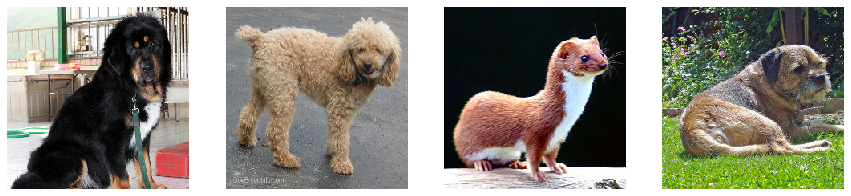

In [55]:
#load all images
imgs = []
for sample in img_files:
    imgs.append(cv2.imread(sample))
    
#plot images
fig = plt.figure(figsize=(15,6))
for i, img in enumerate(imgs):
    fig.add_subplot(1,4,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

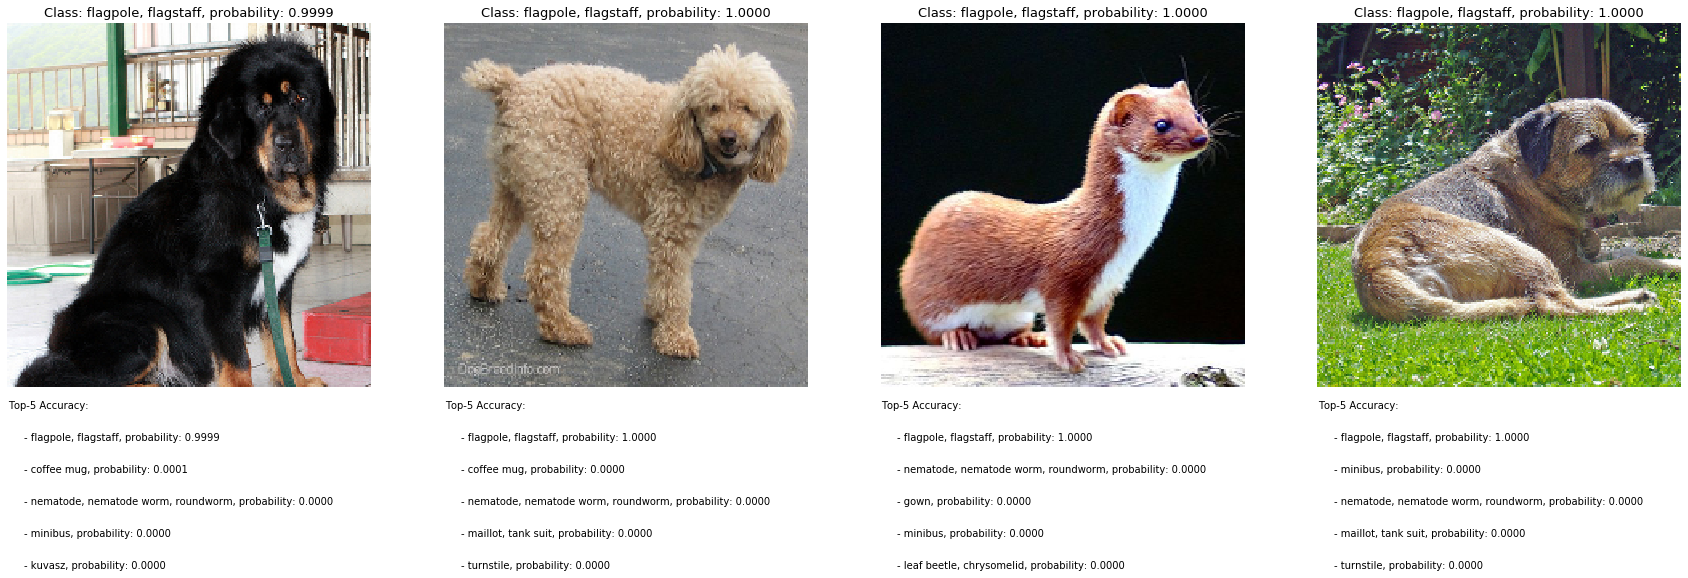

In [65]:
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)
fig2 = plt.figure(figsize=(30,10))

for i, image in enumerate(imgs):
    img = cv2.resize(image.astype(np.float32), (224, 224))
    img -= imagenet_mean
    img = img.reshape((1, 3, 224, 224))
    img = torch.from_numpy(img)
    probs = torch.nn.Softmax(dim=-1)(net(img))
    probs = probs.detach().numpy()
    
    class_name = class_names[np.argmax(probs)]
    
    fig2.add_subplot(1,4,i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Class: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)], fontsize=13)
    plt.axis('off')

    plt.text(0, 240, 'Top-5 Accuracy:')
    x, y = 10, 260
    for idx in np.argsort(probs)[0][-5::][::-1]:
        plt.text(x, y, s ='- {}, probability: {:.4f}'.format(class_names[idx], probs[0, idx]), fontsize=10)
        y += 20
    print()